<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5440_HW22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


Epoch 1/50: 100%|██████████| 274/274 [00:01<00:00, 143.01it/s, loss=3.87]


Epoch 1/50: Accuracy = 8.15%



Epoch 2/50: 100%|██████████| 274/274 [00:01<00:00, 199.27it/s, loss=4.08]


Epoch 2/50: Accuracy = 11.31%



Epoch 3/50: 100%|██████████| 274/274 [00:01<00:00, 195.66it/s, loss=3.68]


Epoch 3/50: Accuracy = 13.13%



Epoch 4/50: 100%|██████████| 274/274 [00:01<00:00, 189.73it/s, loss=3.46]


Epoch 4/50: Accuracy = 14.69%



Epoch 5/50: 100%|██████████| 274/274 [00:01<00:00, 182.59it/s, loss=3.8]


Epoch 5/50: Accuracy = 16.05%



Epoch 6/50: 100%|██████████| 274/274 [00:01<00:00, 190.72it/s, loss=3.63]


Epoch 6/50: Accuracy = 16.67%



Epoch 7/50: 100%|██████████| 274/274 [00:01<00:00, 193.68it/s, loss=3.38]


Epoch 7/50: Accuracy = 17.43%



Epoch 8/50: 100%|██████████| 274/274 [00:01<00:00, 194.06it/s, loss=3.62]


Epoch 8/50: Accuracy = 17.69%



Epoch 9/50: 100%|██████████| 274/274 [00:01<00:00, 194.00it/s, loss=3.26]


Epoch 9/50: Accuracy = 18.39%



Epoch 10/50: 100%|██████████| 274/274 [00:01<00:00, 194.92it/s, loss=3.29]


Epoch 10/50: Accuracy = 18.27%
Best Accuracy: 18.39%


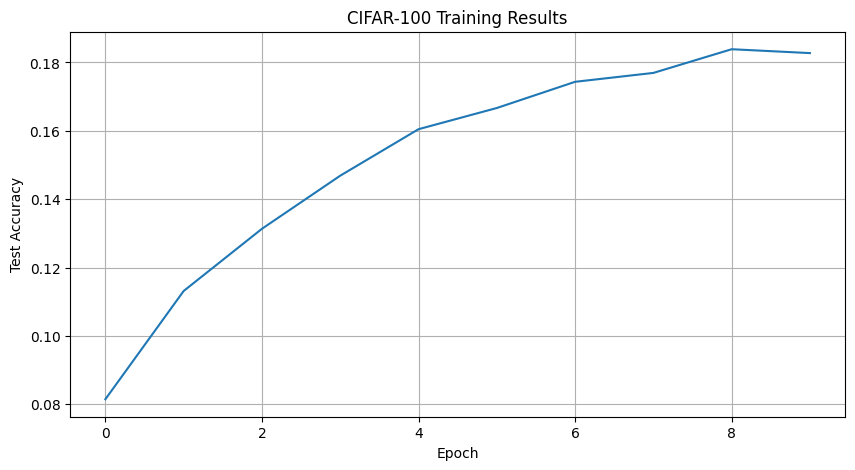

AttributeError: 'SimpleNN' object has no attribute 'history'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import talos as ta
from tqdm import tqdm
from google.colab import drive

drive.mount("/content/drive")
# Load CIFAR-100 dataset
def load_data():
    with open('/content/drive/My Drive/train', 'rb') as file:
        train_dict = pickle.load(file, encoding='bytes')
    with open('/content/drive/My Drive/test', 'rb') as file:
        test_dict = pickle.load(file, encoding='bytes')

    X_train = train_dict[b'data']
    y_train = train_dict[b'coarse_labels']
    X_test = test_dict[b'data']
    y_test = test_dict[b'coarse_labels']

    enc = OneHotEncoder(sparse_output=False, categories='auto')
    y_train = enc.fit_transform(np.array(y_train).reshape(-1, 1))
    y_test = enc.transform(np.array(y_test).reshape(-1, 1))

    X_train = torch.tensor(X_train / 255.0, dtype=torch.float32).reshape(-1, 3072)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test / 255.0, dtype=torch.float32).reshape(-1, 3072)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    return X_train, y_train, X_test, y_test

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size=3072, hidden_size=240, num_classes=100):
        super(SimpleNN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
        self.history = {'epoch': [], 'accuracy': []}  # Store history in the model
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc_layers(x)
        return x

# Train function
def train_model(X_train, y_train, X_test, y_test, params):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    model = SimpleNN(input_size=3072, hidden_size=params['units'], num_classes=100)
    criterion = nn.CrossEntropyLoss() if params['loss'] == 'categorical_crossentropy' else nn.MSELoss()
    optimizer = optim.Adam(model.parameters()) if params['optimizer'] == 'adam' else optim.Adagrad(model.parameters())

    train_loader = data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=params['batch_size'], shuffle=True)
    test_loader = data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=params['batch_size'], shuffle=False)

    #history = {'epoch': [], 'accuracy': []}
    best_acc = 0.0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(20):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/20", leave=True)  # Fixed tqdm

        for batch_X, batch_y in loop:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)

            if isinstance(criterion, nn.CrossEntropyLoss):
                batch_y = torch.argmax(batch_y, dim=1).long()

            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())  # Update progress bar

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(batch_y, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}/20: Accuracy = {accuracy * 100:.2f}%")

        model.history['epoch'].append(epoch)  # Fixed indentation
        model.history['accuracy'].append(accuracy)

        if accuracy > best_acc:
            best_acc = accuracy

    print(f"Best Accuracy: {best_acc * 100:.2f}%")
    df = pd.DataFrame(history)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x='epoch', y='accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('CIFAR-100 Training Results')
    plt.grid()
    plt.savefig("/content/drive/My Drive/cifar100_training_plot.png", dpi=300)
    plt.show()

    return model, history

# Define Talos parameter dictionary
p = {
    'units': [120, 240],
    'hidden_activations': ['relu', 'sigmoid'],
    'loss': ['categorical_crossentropy'],
    'optimizer': ['adam', 'adagrad'],
    'batch_size': [128, 256]
}

# Load data
X_train, y_train, X_test, y_test = load_data()

# Run Talos scan
ta.Scan(x=X_train.numpy(),
        y=y_train.numpy(),
        model=train_model,
        params=p,
        experiment_name='cifar100_talos')


In [ ]:
!pip install --upgrade talos

In [ ]:
!pip install tqdm

In [ ]:
!pip install talos